In [ ]:

import torch.nn as nn
import torch

class LSTMActor(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=64):
        super(LSTMActor, self).__init__()
        self.lstm = nn.LSTM(obs_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Tanh()
        )

    def forward(self, obs_seq, hidden=None):
        # obs_seq: [batch_size, seq_len, obs_dim]
        lstm_out, hidden = self.lstm(obs_seq, hidden)
        out = self.fc(lstm_out[:, -1, :])  # use last time step
        return out, hidden

class LSTMCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, num_agents, hidden_dim=128):
        super(LSTMCritic, self).__init__()
        input_dim = (obs_dim + action_dim) * num_agents
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state_seq, hidden=None):
        lstm_out, hidden = self.lstm(state_seq, hidden)
        q_value = self.fc(lstm_out[:, -1, :])
        return q_value, hidden


In [ ]:

from collections import deque
import random
import numpy as np

class SequenceReplayBuffer:
    def __init__(self, capacity, seq_len=5):
        self.buffer = deque(maxlen=capacity)
        self.seq_len = seq_len

    def push(self, transition):  # transition: (obs_seq, act_seq, rew_seq, next_obs_seq, done_seq)
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        obs_seq, act_seq, rew_seq, next_obs_seq, done_seq = zip(*batch)
        return (
            np.array(obs_seq),
            np.array(act_seq),
            np.array(rew_seq),
            np.array(next_obs_seq),
            np.array(done_seq)
        )

    def __len__(self):
        return len(self.buffer)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path

import torch.nn.utils.spectral_norm as spectral_norm

# 保证实时绘图可在 Colab 中显示
%matplotlib inline

# ✅ 注意：你需要事先上传 env_range_attack.py 并包含 BattleEnv 类
from env_range_attack import BattleEnv
# from env import BattleEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class OUNoise:
    def __init__(self, action_dim, mu=0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state

class SharedActor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.simple1 = nn.Linear(obs_dim, 300)
        self.simple2 = nn.Linear(300, 300)
        self.simple3 = nn.Linear(300, action_dim)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x)
        x = F.relu(self.simple1(x))
        # x = F.relu(self.simple2(x))
        x = self.simple3(x)
        return torch.clamp(x, -1, 1)

    def sample_action(self, x, noise=0):
        return self.forward(x)

class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim, num_agents):
        super().__init__()
        input_dim = obs_dim * num_agents + action_dim * num_agents
        self.norm = nn.BatchNorm1d(input_dim)
        self.net = nn.Sequential(
            spectral_norm(nn.Linear(input_dim, 256)),
            nn.ReLU(),
            spectral_norm(nn.Linear(256, 64)),
            nn.ReLU(),
            spectral_norm(nn.Linear(64, 1))
        )

    def forward(self, obss, actions):
        x = torch.cat([obss, actions], dim=1)
        # x = self.norm(x)
        return self.net(x).to(device)

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def add(self, obs, actions, rewards, next_obs, done):
        self.buffer.append((obs, actions, rewards, next_obs, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        obs, actions, rewards, next_obs, dones = zip(*batch)

        obs = torch.FloatTensor(np.array(obs)).to(device)            # [batch, num_agents, obs_dim]
        actions = torch.FloatTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        next_obs = torch.FloatTensor(np.array(next_obs)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        return obs, actions, rewards, next_obs, dones

    def __len__(self):
        return len(self.buffer)

In [8]:
def expert_learn_A(ep_num):
    use_induce_prob = max(0, 1-ep_num/1000)
    return np.random.random() < use_induce_prob

def expert_learn_B(ep_num):
    if ep_num < 1000:
        use_induce_prob = min(1, ep_num/1000)
        return np.random.random() < use_induce_prob
    return False

def expert_learn_C(ep_num):
    # if ep_num>2000:
    #     return False
    return not bool((ep_num//200)%2)


def normalize_obs(obs, obs_low, obs_high):
    return (obs - obs_low) / (obs_high - obs_low + 1e-8)

def normalize_act(act, act_low, act_high):
    return (act - act_low) / (act_high - act_low + 1e-8)


In [9]:
def train_curriculum(env, actor_lr=1e-4, critic_lr=1e-3, noise_scale=0.2, noise_decay=0.99, gamma=0.95,
                     episodes=3000, batch_size=256, task_code="TaskCurr", is_render=False, dev_render_trail=False,
                     Mix_Method=None, reward_type='task1'):

    from IPython.display import clear_output

    print("Using device:", device)

    num_agents = env.red_agents
    obs_dim = len(env._get_obs(0))
    global_obs_dim = obs_dim * num_agents
    action_dim = 3

    # Initialize networks
    actors = [SharedActor(obs_dim, action_dim).to(device) for _ in range(num_agents)]
    critics = [Critic(obs_dim, action_dim, num_agents).to(device) for _ in range(num_agents)]
    target_actors = [SharedActor(obs_dim, action_dim).to(device) for _ in range(num_agents)]
    target_critics = [Critic(obs_dim, action_dim, num_agents).to(device) for _ in range(num_agents)]

    # Sync target networks
    for i in range(num_agents):
        target_actors[i].load_state_dict(actors[i].state_dict())
        target_critics[i].load_state_dict(critics[i].state_dict())

    # Optimizers
    actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_lr) for actor in actors]
    critic_optimizers = [optim.Adam(critic.parameters(), lr=critic_lr) for critic in critics]
    actor_schedulers = [torch.optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=0.995) for actor_optimizer in actor_optimizers]
    critic_schedulers = [torch.optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=0.995) for critic_optimizer in critic_optimizers]

    buffer = ReplayBuffer()
    ou_noise = OUNoise(action_dim, sigma=noise_scale)

    if Mix_Method is None:
        Mix_Method = lambda *_: False

    save_dir = Path("uniform") / task_code
    save_dir.mkdir(exist_ok=True, parents=True)

    reward_history = []
    reward_enemy_history = []
    reward_history_peri = []
    reward_enemy_history_peri = []
    actor_loss_history = []
    critic_loss_history = []

    win_side_every_100 = []
    red_win_rate = []
    blue_win_rate = []

    fig, axs = plt.subplots(2, 2, figsize=(10, 4))
    ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]

    current_task = reward_type

    for ep in range(episodes + 1):
        ep_start_time = time.time()
        env.reset()
        ou_noise.reset()

        obs_n = env._get_obs_all()[:num_agents]
        episode_reward = 0
        episode_reward_enemy = 0
        a_loss_episode, c_loss_episode = 0, 0

        for step in range(200):
            actions = []
            for r in range(env.red_agents):
                if Mix_Method(ep):
                    actions.append(env.induce_step(r))
                else:
                    obs_tensor = torch.FloatTensor(np.array(obs_n[r])).to(device)
                    action = actors[r].sample_action(obs_tensor).cpu().detach().numpy()
                    noise = ou_noise.sample()
                    action = np.clip(action + noise, -1, 1)
                    actions.append(action)

            for _ in range(env.blue_agents):
                # if ep < 500:
                #     action = np.zeros(3)
                # else:
                #     action = np.random.random(3) * 2 - 1
                action = np.random.random(3) * 2 - 1
                actions.append(action)

            next_obs_n, rewards, done, _ = env.step(actions, reward_type=current_task)
            next_obs_n = next_obs_n[:num_agents]
            rewards_enemy = rewards[num_agents:]
            rewards = rewards[:num_agents]

            buffer.add(obs_n, actions[:num_agents], rewards, next_obs_n, float(done))
            episode_reward += np.mean(rewards)
            episode_reward_enemy += np.mean(rewards_enemy)
            obs_n = next_obs_n

            if is_render:
                env.render(show_trail=dev_render_trail)

            if done:
                break

        if ep > 20 and len(buffer) > batch_size:
            obs_batch, act_batch, rew_batch, next_obs_batch, done_batch = buffer.sample(batch_size)

            a_losses, c_losses = [], []

            for i in range(num_agents):
                all_obs = obs_batch.view(batch_size, -1)
                all_next_obs = next_obs_batch.view(batch_size, -1)
                all_actions = act_batch.view(batch_size, -1)

                with torch.no_grad():
                    target_acts = [target_actors[j](next_obs_batch[:, j, :]) for j in range(num_agents)]
                    target_acts_cat = torch.cat(target_acts, dim=1).to(device)
                    target_q = target_critics[i](all_next_obs, target_acts_cat)
                    target_q = rew_batch[:, i].unsqueeze(1) + (1 - done_batch) * gamma * target_q

                curr_q = critics[i](all_obs, all_actions)
                critic_loss = nn.MSELoss()(curr_q, target_q)
                critic_optimizers[i].zero_grad()
                critic_loss.backward()
                nn.utils.clip_grad_norm_(critics[i].parameters(), max_norm=0.5)
                critic_optimizers[i].step()

                curr_acts = [actors[j](obs_batch[:, j, :]).detach() if j != i else actors[j](obs_batch[:, j, :]) for j in range(num_agents)]
                curr_acts_cat = torch.cat(curr_acts, dim=1).to(device)
                actor_loss = -critics[i](all_obs, curr_acts_cat).mean()
                actor_optimizers[i].zero_grad()
                actor_loss.backward()
                nn.utils.clip_grad_norm_(actors[i].parameters(), max_norm=0.5)
                actor_optimizers[i].step()

                actor_schedulers[i].step()
                critic_schedulers[i].step()

                # actor_loss_history.append(actor_loss.item())
                # critic_loss_history.append(critic_loss.item())

                a_losses.append(actor_loss.item())
                c_losses.append(critic_loss.item())

            a_loss_episode = np.mean(a_losses)
            c_loss_episode = np.mean(c_losses)

            actor_loss_history.append(a_loss_episode)
            critic_loss_history.append(c_loss_episode)

        ep_end_time = time.time()
        reward_history.append(episode_reward)
        reward_history_peri.append(np.mean(reward_history[-100:]))
        reward_enemy_history.append(episode_reward_enemy)
        reward_enemy_history_peri.append(np.mean(reward_enemy_history[-100:]))

        outcome = env.decide_outcome()
        if len(win_side_every_100) >= 100:
            win_side_every_100.pop(0)
        win_side_every_100.append(1 if 'red' in outcome else -1 if 'blue' in outcome else 0)

        if ep >= 10:
            red_win_rate.append(win_side_every_100.count(1) / len(win_side_every_100))
            blue_win_rate.append(win_side_every_100.count(-1) / len(win_side_every_100))

        if ep % 10 == 0:
            noise_scale *= noise_decay
            ou_noise.sigma = noise_scale

        log_text = (f"[Ep {ep}] Reward: {episode_reward:.2f}, Task: {current_task}, a_loss: {a_loss_episode:.2f}, c_loss:{c_loss_episode:.2f}, "
                    f"Noise: {noise_scale:.2f}, Time: {ep_end_time - ep_start_time:.2f}, Outcome: {outcome}")
        # print(log_text)
        with open(save_dir / "log.txt", "a") as f:
            f.write(log_text + "\n")

        env.save_and_clear(ep, save_dir / f"record_part_{ep // 100}.jsonl")
        env.save_and_clear_rewards(ep, save_dir / f"reward_part_{ep // 100}.csv")

        save_pic_interval = 10
        if ep>=20  and ep % save_pic_interval == 0:
            clear_output(wait=True)
            plt.close(fig)
            fig, axs = plt.subplots(2, 2, figsize=(10, 4))
            ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]

            ax1.clear()
            ax1.plot(reward_enemy_history_peri, label='Blue Reward', color='blue')
            ax1.plot(reward_history_peri, label='Red Reward', color='red')
            ax1.set_title(f"Average Reward (Outperform: {np.mean(reward_history_peri) - np.mean(reward_enemy_history_peri):.2f})")
            ax1.legend()

            ax2.clear()
            ax2.plot(blue_win_rate, label='Blue Win Rate', color='blue')
            ax2.plot(red_win_rate, label='Red Win Rate', color='red')
            ax2.set_title(f'Win rate ({np.mean(red_win_rate):.2f}/{np.mean(blue_win_rate):.2f})')
            ax2.legend()

            ax3.clear()
            ax3.plot(actor_loss_history, label='Actor Loss', color='red')
            ax3.set_title('Actor Loss')
            ax3.legend()

            ax4.clear()
            ax4.plot(critic_loss_history, label='Critic Loss', color='green')
            ax4.set_title('Critic Loss')
            ax4.legend()

            plt.tight_layout()
            plt.show()
            # plt.savefig(save_dir / f"figure_ep{ep}.png")

    return

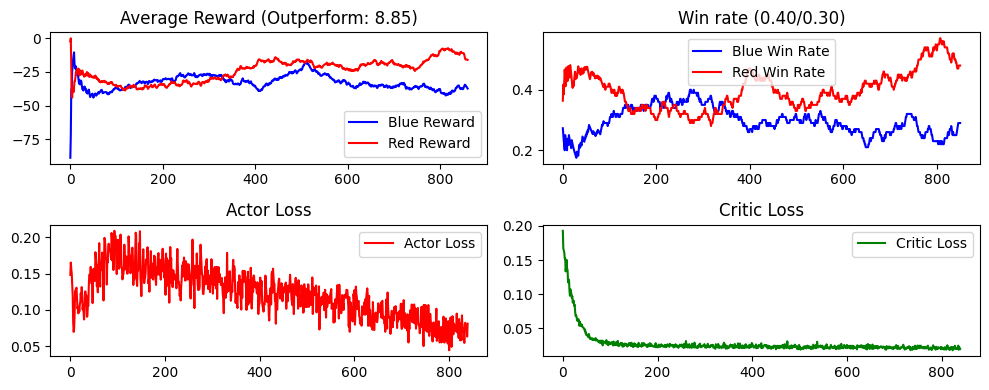

In [ ]:
env = BattleEnv(red_agents=3,
                blue_agents=3,
                auto_record=False,
                developer_tools=False,
                margin_crash=False,
                collision_crash=False)

train_curriculum(env,
                  actor_lr=1e-4,
                  critic_lr=1e-3,
                  episodes=3000,
                  noise_scale=0.6,
                  noise_decay=0.99,
                  task_code="32_Colab_Test",
                  is_render=False,
                  dev_render_trail=True,
                  Mix_Method=None,
                  reward_type='sector')